In [1]:
"""PARAMETERS TO CAPTURE ON STDIN VIA PAPERMILL...."""
#config_path = 'configs/species_experiments/Escherichia_coli_lysate.yaml'
#config_path = 'configs/global_loss_composed_globalAvgtm/global_allmeltome.yaml'
#config_path = 'configs/global_loss_composed_globalAvgtm/global_allmeltome_cleaned.yaml'
config_path = 'configs/species_experiments_loss_composed_globalAvgtm_cleanup/loss2/Arabidopsis_thaliana_seedling_lysate.yaml'


In [2]:
# Parameters
config_path = "configs/global_loss_composed_globalAvgtm/global_allmeltome_cleaned.yaml"


In [3]:
import yaml

print(f"the value of path captured is: {config_path}")

with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
    
#print(config)
#print(f"the value of path captured is: {config_path}")

the value of path captured is: configs/global_loss_composed_globalAvgtm/global_allmeltome_cleaned.yaml


In [4]:
#import ipdb; ipdb.set_trace()

path_progresESM    = config['initial_paths']['path_progresESM']
checkpoint_pathESM = config['initial_paths']['checkpoint_pathESM']

path_progresPiFold    = config['initial_paths']['path_progresPiFold']
checkpoint_pathPiFold = config['initial_paths']['checkpoint_pathPiFold']


path_progresMix= config['initial_paths']['path_progresMix']
#checkpoint_pathMix='../checkpoints/LA_MLP_TaskVectorBias_Merged_allnet_1_10_2023_finetunning_NoMLPincNoBN_lrx00001_lossmod/'
checkpoint_pathMix= config['initial_paths']['checkpoint_pathMix']


organism = config['organism']['organism']
keyword = config['organism']['keyword']

#ESM_source = 'esm2_embeddings'
ESM_source = config['initial_paths']['ESM_source']
PiFold_source = config['initial_paths']['PiFold_source']

prepro_train_emb_ESM = config['initial_paths']['prepro_train_emb_ESM']
prepro_test_emb_ESM  = config['initial_paths']['prepro_test_emb_ESM']
prepro_val_emb_ESM   = config['initial_paths']['prepro_val_emb_ESM']

prepro_train_emb_PiFold = config['initial_paths']['prepro_train_emb_PiFold']
prepro_test_emb_PiFold  = config['initial_paths']['prepro_test_emb_PiFold']
prepro_val_emb_PiFold   = config['initial_paths']['prepro_val_emb_PiFold']

In [5]:
import __init__

from src.utilities import train_test_validation_splits, \
                            prepare_train_test_val_seqs_by_batches, \
                            tensor2dataloader, load_full_meltome_FLIP_db, \
                            seek_UniprotID_association_Meltome_prots,\
                            download_UniprotID_Alphafold_Structures,\
                            get_guided_encoder_output,\
                            ESM2_IF_repr
                            
import pandas as pd
import numpy as np
    
import ipdb
path_meltome = config['meltome']['path_meltome']
complete_meltome_db = config['meltome']['complete_meltome_db']

full_meltome_db = load_full_meltome_FLIP_db(complete_meltome_db)

splits_meltome = pd.read_csv(path_meltome, sep=',')

#import ipdb; ipdb.set_trace()

splits_meltome = seek_UniprotID_association_Meltome_prots(splits_meltome, full_meltome_db)
split_meltome = splits_meltome[splits_meltome['sequence'].str.len()>= 50]
#import ipdb; ipdb.set_trace()
'''------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------'''
'''                      JUST FILTERING TO TAKE BACTERIA AND IGNORE EUKARIOTIC SAMPLES (HUMAN, PLANTS, CANCER CELLS, ETC)        '''

list_bacteria = [ "Caenorhabditis_elegans_lysate", "Saccharomyces_cerevisiae_lysate", "Escherichia_coli_lysate", 
                 "Escherichia_coli_cells", "Bacillus_subtilis_168_lysate_R1", "Oleispira_antarctica_RB-8_lysate_R1", 
                 "Picrophilus_torridus_DSM9790_lysate", "Thermus_thermophilus_HB27_cells", 
                 "Geobacillus_stearothermophilus_NCA26_lysate", "Thermus_thermophilus_HB27_lysate"]
#splits_meltome = splits_meltome[ splits_meltome.organism.isin( list_bacteria ) ]

'''------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------'''

train, val, test = train_test_validation_splits(splits_meltome)

print("Done")



Done


In [6]:
import torch
import src.IF_PiFold_embeddings  as PiFoldconf 
#from src.IF_PiFold_embeddings import PiFold_setup


args = PiFoldconf.get_parser()
exp = PiFoldconf.PiFold_setup(args)
svpath = config['Pifold_pretrain']['svpath']
exp.method.load_state_dict(torch.load(svpath+'checkpoint.pth'))


Use GPU: cuda:0



device: 	cuda	
display_step: 	10	
res_dir: 	results	
ex_name: 	ProDesign	
use_gpu: 	True	
gpu: 	0	
seed: 	111	
data_name: 	CATH	
data_root: 	data/	
batch_size: 	8	
num_workers: 	8	
method: 	ProDesign	
config_file: 	None	
hidden_dim: 	128	
node_features: 	128	
edge_features: 	128	
k_neighbors: 	30	
dropout: 	0.1	
num_encoder_layers: 	10	
epoch: 	100	
log_step: 	1	
lr: 	0.001	
patience: 	100	
updating_edges: 	4	
node_dist: 	1	
node_angle: 	1	
node_direct: 	1	
edge_dist: 	1	
edge_angle: 	1	
edge_direct: 	1	
virtual_num: 	3	


<All keys matched successfully>

In [7]:
from tqdm.auto import tqdm
import torch
from src.ESM2embeddings import ESM2embeddings
from src.ESM2_IF1_embeddings import ESM2_IF1_embeddings
from src.utilities import train_test_validation_splits, prepare_train_test_val_seqs_by_batches, tensor2dataloader,read_and_plot_loss_curves, cleanup_by_organism_and_correspondence_idx
from src.NeuralArchitectures import regressionHead

from src.AdaptiveDataset import AdaptiveDataset

structuredir =  config['structures_path']['structuredir']
meltome_struct_dir_labels =  config['structures_path']['meltome_struct_dir_labels']

#import ipdb; ipdb.set_trace()
import os 
if not os.listdir(structuredir) and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_train.txt')\
                                and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_test.txt')\
                                and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_val.txt'): 
    
    print("Finding structures to proteins via Alphafold/PDB dbs..........") 
    
    download_UniprotID_Alphafold_Structures(train, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_train')
    download_UniprotID_Alphafold_Structures(test, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_test')
    download_UniprotID_Alphafold_Structures(val, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_val')


#import ipdb; ipdb.set_trace()
Structinfo_Meltome_Splits_train = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_train.txt', sep='\t').set_index(train.index)
Structinfo_Meltome_Splits_test = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_test.txt', sep='\t').set_index(test.index)
Structinfo_Meltome_Splits_val = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_val.txt', sep='\t').set_index(val.index)


#import ipdb; ipdb.set_trace()

train = pd.concat([train, Structinfo_Meltome_Splits_train], axis=1).query('Source=="alphafold"')
test = pd.concat([test, Structinfo_Meltome_Splits_test], axis=1).query('Source=="alphafold"')
val = pd.concat([val, Structinfo_Meltome_Splits_val], axis=1).query('Source=="alphafold"')

"""
import ipdb; ipdb.set_trace()
if config['organism']['Global']==True:
    idxdf_idxfile_train, _ = cleanup_by_organism_and_correspondence_idx(train, organism, keyword)
    idxdf_idxfile_test, _ = cleanup_by_organism_and_correspondence_idx(test, organism, keyword)
    idxdf_idxfile_val, _ = cleanup_by_organism_and_correspondence_idx(val, organism, keyword)
    
    if 'umap_clusters_clean_meltome_train' in config['meltome']:
        clusters=pd.read_csv(config['meltome']['umap_clusters_clean_meltome_train'], sep='\t').cluster.tolist()
        train['umap_clusters'] = clusters
        train =  train[train.umap_clusters !=-1]
    
else:
    idxdf_idxfile_train, train = cleanup_by_organism_and_correspondence_idx(train, organism, keyword)
    idxdf_idxfile_test, test = cleanup_by_organism_and_correspondence_idx(test, organism, keyword)
    idxdf_idxfile_val, val = cleanup_by_organism_and_correspondence_idx(val, organism, keyword)
"""
if 'umap_clusters_clean_meltome_train' in config['meltome']:
    clusters=pd.read_csv(config['meltome']['umap_clusters_clean_meltome_train'], sep='\t').cluster.tolist()
    # cluster keys columns are related to the dictionary from cleanup_by_organism_and_correspondence_idx method
    # so if you need a mapping of the sample, you need to use that index to get the proper sampled idx from original
    # pandas dataframe. Recap : idx_numbering -> pandas_idx_original_cleaned_data
    train['umap_clusters'] = clusters

if config['organism']['Global']==True:
    idxdf_idxfile_train, _ = cleanup_by_organism_and_correspondence_idx(train, organism, keyword)
    idxdf_idxfile_test, _ = cleanup_by_organism_and_correspondence_idx(test, organism, keyword)
    idxdf_idxfile_val, _ = cleanup_by_organism_and_correspondence_idx(val, organism, keyword)
    
    if 'umap_clusters_clean_meltome_train' in config['meltome']:
        train =  train[train.umap_clusters !=-1]
    
else:
    idxdf_idxfile_train, train = cleanup_by_organism_and_correspondence_idx(train, organism, keyword)
    idxdf_idxfile_test, test = cleanup_by_organism_and_correspondence_idx(test, organism, keyword)
    idxdf_idxfile_val, val = cleanup_by_organism_and_correspondence_idx(val, organism, keyword)
    
    if 'umap_clusters_clean_meltome_train' in config['meltome']:
        train =  train[train.umap_clusters !=-1]


'''------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------'''
'''                      JUST FILTERING TO TAKE BACTERIA AND IGNORE EUKARIOTIC SAMPLES (HUMAN, PLANTS, CANCER CELLS, ETC)        '''

#train = train[ train.organism.isin( list_bacteria ) ]
#test = test[ test.organism.isin( list_bacteria ) ]
#val = val[ val.organism.isin( list_bacteria ) ]

'''------------------------------------------------------------------------------------------------------------------------------'''
'''------------------------------------------------------------------------------------------------------------------------------'''

'------------------------------------------------------------------------------------------------------------------------------'

In [8]:
train.shape
print(train)
print(train.columns)
#train.to_csv('../datasets/train_MeltomeMix_for_cleaning.csv', sep="\t", index=False)
#import ipdb; ipdb.set_trace()
"""
# temp fasta file convertion to cleaning
with open('../datasets/train_MeltomeMix_for_cleaning.csv.fasta', 'w') as f:
    for k, v in zip(train.index.tolist(),train.sequence):
        f.write(f'>{k}\n{v}\n')
"""

                                                sequence            target  \
0      MSGEEEKAADFYVRYYVGHKGKFGHEFLEFEFRPNGSLRYANNSNY...  37.9629473421417   
1      MSMGSDFYLRYYVGHKGKFGHEFLEFEFRPDGKLRYANNSNYKNDV...  54.4253424806097   
2      MRICFLLLAFLVAETFANELTRCCAGGTRHFKNSNTCSSIKSEGTS...  49.4592155176475   
3      MIRVALPTTASAIPRSISTSPGETISKNHEEEVKRVWRKADAVCFD...  42.5931308043435   
4      MNGDWSRAFVLSKVKNLYFFVIIDKGFSAILNDPREPVQVGGFFEV...  37.9994780790578   
...                                                  ...               ...   
27944  MAVVLPAVVEELLSEMAAAVQESARIPDEYLLSLKFLFGSSATQAL...  56.8600005753223   
27945  MLSCNICGETVTSEPDMKAHLIVHMESEIICPFCKLSGVNYDEMCF...  45.1243026020368   
27946  MDLPALLPAPTARGGQHGGGPGPLRRAPAPLGASPARRRLLLVRGP...   47.008000426981   
27947  MPEDQAGAAMEEASPYSLLDICLNFLTTHLEKFCSARQDGTLCLQE...  51.8978809719254   
27948  MAAPRPSPAISVSVSAPAFYAPQKKFGPVVAPKPKVNPFRPGDSEP...  63.5734388197048   

         set  validation  protein_id  \
0      train       Fals

"\n# temp fasta file convertion to cleaning\nwith open('../datasets/train_MeltomeMix_for_cleaning.csv.fasta', 'w') as f:\n    for k, v in zip(train.index.tolist(),train.sequence):\n        f.write(f'>{k}\n{v}\n')\n"

In [9]:

import torch, os, gc
import torch_geometric
import torch_sparse
from torch_geometric.nn import MessagePassing
import warnings
warnings.filterwarnings('ignore')



pt_batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ESM2 = ESM2embeddings(type_embedding = "facebook/esm2_t33_650M_UR50D", device = device, type_tool='FacebookESM2')

dir_pre_generated_embeddings =  config['ESM2embeddings']['dir_pre_generated_embeddings'] 
dir_IFPiFold_Meltome_train = dir_pre_generated_embeddings + PiFold_source + '/Meltome_train/'
dir_IFPiFold_Meltome_test = dir_pre_generated_embeddings +  PiFold_source + '/Meltome_test/'
dir_IFPiFold_Meltome_val = dir_pre_generated_embeddings +  PiFold_source + '/Meltome_val/'


path_train= dir_pre_generated_embeddings+prepro_train_emb_ESM
path_test= dir_pre_generated_embeddings+prepro_test_emb_ESM
path_val= dir_pre_generated_embeddings+prepro_val_emb_ESM

"""
path_esm2_train= dir_pre_generated_embeddings+'esm2_embeddings/train/'
path_esm2_test= dir_pre_generated_embeddings+'esm2_embeddings/test/'
path_esm2_val= dir_pre_generated_embeddings+'esm2_embeddings/val/'
"""

path_esm2_train= dir_pre_generated_embeddings+ESM_source+'/Meltome/train/'
path_esm2_test= dir_pre_generated_embeddings+ESM_source+'/Meltome/test/'
path_esm2_val= dir_pre_generated_embeddings+ESM_source+'/Meltome/val/'




def padding_tensor( a, size_end ,val_pad=0):
    a_size = a.shape
    f_size = torch.zeros(size_end[0], size_end[1])
    
    if size_end[0]>=a_size[0]:
        f_size[0:a_size[0]] = a
    else:
        f_size = a[0:size_end[0]]
    return f_size

def ensemble_dataset_from_IF_embeddings(folder_path, max_size=600, dim_IF=128):
    import os
    
    paths = os.listdir(folder_path)
    list_max=[]
    tensor_container = torch.zeros(len(paths),max_size,dim_IF)
    print('Starting load of Inverse Folding Embeddings:  \n')
    
    for i in tqdm(range(0,len(paths))):
        tmp_tensor = torch.load(folder_path+paths[i])
        list_max.append(tmp_tensor.shape[0])
        tmp_tensor = padding_tensor(tmp_tensor, [max_size,dim_IF])
        tensor_container[i]=tmp_tensor
        
    print('maximum structure length in meltome: ' + str(max(list_max)))
    return tensor_container
              

def embedding_builder_ESM2(ESM2, device, train, test, val, path_train, path_test, path_val):
    if os.path.isfile(path_train)==False and os.path.isfile(path_test)==False and os.path.isfile(path_val)==False:
        print ("Creating Embeddings...")   
        train_embeddings = ESM2.esm2embedding(train, device, layer_index=33,folder_path=path_esm2_train) #esm2embedding(train, model, batch_converter, device, layer_index=33)#BERT.embed_dataset(batch_train)
        torch.save(train_embeddings, path_train)
        test_embeddings = ESM2.esm2embedding(test, device, layer_index=33,folder_path=path_esm2_test) #esm2embedding(test, model, batch_converter, device, layer_index=33)
        torch.save(test_embeddings, path_test)
        val_embeddings = ESM2.esm2embedding(val, device, layer_index=33,folder_path=path_esm2_val) #esm2embedding(val, model, batch_converter, device, layer_index=33)
        torch.save(val_embeddings, path_val)
        print ("Loaded")
    else:
        print ("Loading Premade Embeddings...")
        train_embeddings = torch.load(path_train)
        test_embeddings = torch.load(path_test)
        val_embeddings = torch.load(path_val)
        print ("Loaded")
    return train_embeddings, test_embeddings, val_embeddings

#def IFBuilder_sets(model, alphabet, train, test, val, path_IFtrain, path_IFtest, path_IFval):
def IFBuilder_sets(IF, train, test, val, path_IFtrain, path_IFtest, path_IFval):

    if len(os.listdir(path_IFtrain))==0 and len(os.listdir(path_IFtest))==0 and len(os.listdir(path_IFval))==0: #os.path.isfile(path_IFtrain)==False and os.path.isfile(path_IFtest)==False and os.path.isfile(path_IFval)==False:

        #IF_embeddings_train = ESM2_IF_repr(train, model, alphabet, folder_path='../prepro_embeddings/esm2_if1_embeddings/Meltome_train')
        IF_embeddings_train = IF.IF_repr(train, folder_path='../prepro_embeddings/PiFold_if1_embeddings/Meltome_train')
        torch.save(IF_embeddings_train, path_IFtrain)

        #IF_embeddings_test = ESM2_IF_repr(test, model, alphabet, folder_path='../prepro_embeddings/esm2_if1_embeddings/Meltome_test')
        IF_embeddings_test = IF.IF_repr(test, folder_path='../prepro_embeddings/PiFold_if1_embeddings/Meltome_test')
        torch.save(IF_embeddings_test, path_IFtest)

        #IF_embeddings_val = ESM2_IF_repr(val, model, alphabet, folder_path='../prepro_embeddings/esm2_if1_embeddings/Meltome_val')
        IF_embeddings_val = IF.IF_repr(val, folder_path='../prepro_embeddings/PiFold_if1_embeddings/Meltome_val')
        torch.save(IF_embeddings_val, path_IFval)
    else:
        print ("Loading Premade Embeddings...")
        # 2700 is the maximum size of protein structure extracted from Alphafold DB to Meltome Atlas 
        #ipdb.set_trace()
        IF_embeddings_train = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_train,max_size=2700)
        IF_embeddings_test = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_test, max_size=2700)
        IF_embeddings_val = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_val, max_size=2700)
        print ("Loaded")
    return IF_embeddings_train, IF_embeddings_test, IF_embeddings_val

# 2700 is the maximum size of protein structure extracted from Alphafold DB to Meltome Atlas 
'''
IF_embeddings_train = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_train,max_size=2700)
IF_embeddings_test = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_test, max_size=2700)
IF_embeddings_val = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_val, max_size=2700)
'''


'\nIF_embeddings_train = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_train,max_size=2700)\nIF_embeddings_test = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_test, max_size=2700)\nIF_embeddings_val = ensemble_dataset_from_IF_embeddings(dir_IFPiFold_Meltome_val, max_size=2700)\n'

In [10]:
#_, _, _ = embedding_builder_ESM2(ESM2, device, train, test, val,  path_train, path_test, path_val)

train_embedding_esm2 = torch.utils.data.DataLoader( AdaptiveDataset(train, path_esm2_train, dir_IFPiFold_Meltome_train, 
                                                   emb_ensemble = 'single', type_emb='esm2',
                                                   correspondence_idx = idxdf_idxfile_train ) , batch_size=150, shuffle=True)
test_embedding_esm2 = torch.utils.data.DataLoader( AdaptiveDataset(test, path_esm2_test, dir_IFPiFold_Meltome_test, 
                                                    emb_ensemble = 'single', type_emb='esm2',
                                                   correspondence_idx = idxdf_idxfile_test) , batch_size=150, shuffle=True)
val_embedding_esm2 = torch.utils.data.DataLoader( AdaptiveDataset(val, path_esm2_val, dir_IFPiFold_Meltome_val, 
                                                    emb_ensemble = 'single', type_emb='esm2',
                                                   correspondence_idx = idxdf_idxfile_val) , batch_size=150, shuffle=True)

train_embedding_PiFold = torch.utils.data.DataLoader( AdaptiveDataset(train, path_esm2_train, dir_IFPiFold_Meltome_train, 
                                                    emb_ensemble = 'single', type_emb='PiFold',
                                                   correspondence_idx = idxdf_idxfile_train) , batch_size=150, shuffle=True)
test_embedding_PiFold = torch.utils.data.DataLoader( AdaptiveDataset(test, path_esm2_test, dir_IFPiFold_Meltome_test,
                                                    emb_ensemble = 'single', type_emb='PiFold',
                                                   correspondence_idx = idxdf_idxfile_test) , batch_size=150, shuffle=True)
val_embedding_PiFold = torch.utils.data.DataLoader( AdaptiveDataset(val, path_esm2_val, dir_IFPiFold_Meltome_val,
                                                    emb_ensemble = 'single', type_emb='PiFold',
                                                   correspondence_idx = idxdf_idxfile_val) , batch_size=150, shuffle=True)


train_embedding_merged = torch.utils.data.DataLoader( AdaptiveDataset(train, path_esm2_train, dir_IFPiFold_Meltome_train, 
                                                    emb_ensemble = 'merged', type_emb='both',
                                                   correspondence_idx = idxdf_idxfile_train) , batch_size=150, shuffle=True)
test_embedding_merged = torch.utils.data.DataLoader( AdaptiveDataset(test, path_esm2_test, dir_IFPiFold_Meltome_test, 
                                                    emb_ensemble = 'merged', type_emb='both',
                                                   correspondence_idx = idxdf_idxfile_test) , batch_size=150, shuffle=True)
val_embedding_merged = torch.utils.data.DataLoader( AdaptiveDataset(val, path_esm2_val, dir_IFPiFold_Meltome_val, 
                                                    emb_ensemble = 'merged', type_emb='both',
                                                   correspondence_idx = idxdf_idxfile_val) , batch_size=150, shuffle=True)

In [11]:
from src.NeuralArchitectures import *

import ipdb

import os
from os import listdir
from os.path import isfile, join

def generating_results_approaches(FFNNreg, Trner, train_loader, val_loader, test_loader,loss, opt, epochs, device,
                                  path_progres='train_progress_k1_b10.txt', 
                                  checkpoint_path='../checkpoints/k1_b10/',
                                  output_metrics='metrics_per_species/Ecoli_Lysate.txt'):
    if os.path.exists(checkpoint_path):
        if os.path.exists(checkpoint_path+path_progres):
            tmp=checkpoint_path+path_progres
            onlyfiles = os.listdir(checkpoint_path) #[f for f in listdir(tmp) if isfile(join(tmp, f))]
            bestepoch = onlyfiles[-1]
            #parse_progress = "\n".join(s for s in onlyfiles if 'train' in s)
            read_and_plot_loss_curves(checkpoint_path+path_progres)
            
            FFNNreg, _, _, _ = \
                    Trner.load_checkpoint(
                        checkpoint_path+bestepoch, FFNNreg, opt
                        )
            FFNNreg=FFNNreg.to(device)
            
    else:
        FFNNreg, val_loss = Trner.train_LLMRegresor(train_loader, val_loader, FFNNreg, device, loss, opt, epochs,
                                                path_progres, checkpoint_path)

    #test_set, test_labels = next(test_loader)#.dataset.tensors
    test_labels, outcome = Trner.test_model(FFNNreg, test_loader, loss, device)

    from src.utilities import plot_results
    #ipdb.set_trace()
    
    if not os.path.exists( '/'.join(output_metrics.split('/')[:-1]) ):
        os.makedirs( '/'.join(output_metrics.split('/')[:-1]) )
        
    with open( output_metrics, "w") as file1:
        from torchmetrics import SpearmanCorrCoef
        loss_test = torch.nn.MSELoss()(outcome, test_labels)
        mae = torch.nn.L1Loss()(outcome, test_labels)
        
        spearman = SpearmanCorrCoef()
        spear_corr = spearman(outcome.flatten(), test_labels.flatten())
        file1.write('MSE: ' + str(loss_test) +"\n")
        file1.write('RMSE: ' + str(torch.sqrt(loss_test)) +"\n")
        file1.write('MAE: ' + str(mae) +"\n")
        file1.write('Spearman Corr: ' + str(spear_corr))
    

    plot_results( outcome, test_labels)





In [12]:
from src.Trainer_seq_struct2 import Trainer_Seq_Struct2

Trainer3 = Trainer_Seq_Struct2(avgtm_mode='global')

from src.NeuralArchitectures import *


class BiasOrganismLoss(torch.nn.Module):
    
    def __init__(self, device):
        super(BiasOrganismLoss, self).__init__()
        self.device = device
        self.MSE = torch.nn.MSELoss()        
             
    def forward(self, predOGTTM: torch.tensor , target: torch.tensor, avg_TmOrganism: torch.tensor):
        #import ipdb; ipdb.set_trace()
        #return self.MSE( (predOGTTM[:,0] ).unsqueeze(-1), target.to(self.device))
        return self.MSE( (predOGTTM[:,0] + predOGTTM[:,1]).unsqueeze(-1), target.to(self.device))  + self.MSE( predOGTTM[:,0].unsqueeze(-1) , avg_TmOrganism) 


### For RAW ESM2 Using Prediction by Component (convolutions as a way of pooling + sum pooling to get the final predictions)

Directory '../checkpoints/ESM2_only/Global/AllMeltome_cleaned_globalAvgtm/' created


  0%|          | 0/200 [00:00<?, ?it/s]

training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 1 loss: 1550.501 val loss: 121.323


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 2 loss: 117.505 val loss: 85.730


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 3 loss: 85.300 val loss: 59.559


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 4 loss: 58.075 val loss: 50.590


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 5 loss: 45.066 val loss: 42.684


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 6 loss: 38.304 val loss: 43.375


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 7 loss: 33.200 val loss: 37.907


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 8 loss: 28.283 val loss: 111.955


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 9 loss: 29.358 val loss: 39.417


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 10 loss: 32.908 val loss: 1335.874


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 11 loss: 28.043 val loss: 653.959


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 12 loss: 25.982 val loss: 550.507


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 13 loss: 23.617 val loss: 43.739


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 14 loss: 23.638 val loss: 36.003


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 15 loss: 22.573 val loss: 37.651


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 16 loss: 20.938 val loss: 39.038


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 17 loss: 19.291 val loss: 36.073


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 18 loss: 20.249 val loss: 36.405


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 19 loss: 18.281 val loss: 38.028


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 20 loss: 18.325 val loss: 37.368


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 21 loss: 18.113 val loss: 38.543


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 22 loss: 17.464 val loss: 35.526


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 23 loss: 17.108 val loss: 39.348


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 24 loss: 17.574 val loss: 52.816


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 25 loss: 16.623 val loss: 39.736


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 26 loss: 16.011 val loss: 38.414


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 27 loss: 15.289 val loss: 37.061


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 28 loss: 15.235 val loss: 42.423


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 29 loss: 14.949 val loss: 42.595


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 30 loss: 13.603 val loss: 36.954


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 31 loss: 13.950 val loss: 37.968


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 32 loss: 13.585 val loss: 36.296


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 33 loss: 13.560 val loss: 38.126


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 34 loss: 13.091 val loss: 43.737


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 35 loss: 13.201 val loss: 46.353


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 36 loss: 12.505 val loss: 38.083


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 37 loss: 12.507 val loss: 41.634


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 38 loss: 11.921 val loss: 39.298


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 39 loss: 12.888 val loss: 46.622


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 40 loss: 13.206 val loss: 45.160


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 41 loss: 11.672 val loss: 49.976


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 42 loss: 11.778 val loss: 45.247


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 43 loss: 10.842 val loss: 47.760


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 44 loss: 11.741 val loss: 49.430


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 45 loss: 11.861 val loss: 39.565


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 46 loss: 10.999 val loss: 48.303


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 47 loss: 11.404 val loss: 56.132


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 48 loss: 11.241 val loss: 40.994


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 49 loss: 11.473 val loss: 253.302


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 50 loss: 11.076 val loss: 267.772


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 51 loss: 10.942 val loss: 547.428


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 52 loss: 11.057 val loss: 272.042


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 53 loss: 10.385 val loss: 50.515


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 54 loss: 10.568 val loss: 7961.888


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 55 loss: 9.842 val loss: 169.067


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 56 loss: 10.482 val loss: 116.458


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 57 loss: 10.432 val loss: 4583.781


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 58 loss: 10.695 val loss: 2713.382


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 59 loss: 9.879 val loss: 3198.114


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 60 loss: 9.983 val loss: 59.909


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 61 loss: 9.828 val loss: 3289.115


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 62 loss: 9.883 val loss: 49.719


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 63 loss: 9.699 val loss: 54.609


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 64 loss: 8.881 val loss: 24571.931


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 65 loss: 9.716 val loss: 9218.399


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 66 loss: 9.654 val loss: 9567.347


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 67 loss: 9.128 val loss: 69759.802


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 68 loss: 10.789 val loss: 695.790


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 69 loss: 10.526 val loss: 10514.796


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 70 loss: 9.559 val loss: 8774.137


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 71 loss: 10.267 val loss: 440.352


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 72 loss: 8.243 val loss: 2274.928


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 73 loss: 8.541 val loss: 45.970


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 74 loss: 9.245 val loss: 366.160


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 75 loss: 9.488 val loss: 415.906


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 76 loss: 8.842 val loss: 101.097


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 77 loss: 8.838 val loss: 1308.205


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 78 loss: 8.191 val loss: 492.184


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 79 loss: 8.168 val loss: 479.457


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 80 loss: 8.703 val loss: 57.006


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 81 loss: 8.495 val loss: 49.834


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 82 loss: 7.775 val loss: 1283.332


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 83 loss: 8.283 val loss: 136.220


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 84 loss: 8.435 val loss: 49.389


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 85 loss: 8.561 val loss: 388.978


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 86 loss: 8.129 val loss: 85.112


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 87 loss: 9.409 val loss: 50.276


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 88 loss: 8.479 val loss: 1981.457


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 89 loss: 8.439 val loss: 77.876


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 90 loss: 8.256 val loss: 20853.834


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 91 loss: 9.031 val loss: 50.026


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 92 loss: 8.716 val loss: 2210.027


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 93 loss: 7.896 val loss: 70.806


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 94 loss: 8.363 val loss: 54.331


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 95 loss: 7.871 val loss: 74.480


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 96 loss: 8.037 val loss: 77.742


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 97 loss: 8.189 val loss: 61.657


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 98 loss: 7.546 val loss: 60.684


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 99 loss: 8.011 val loss: 66.994


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 100 loss: 8.508 val loss: 70.263


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 101 loss: 8.435 val loss: 51.588


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 102 loss: 8.291 val loss: 76.932


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 103 loss: 8.202 val loss: 70.987


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 104 loss: 7.276 val loss: 82.351


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 105 loss: 7.973 val loss: 61.468


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 106 loss: 7.209 val loss: 62.143


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 107 loss: 7.296 val loss: 80.831


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 108 loss: 7.979 val loss: 58.583


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 109 loss: 8.064 val loss: 59.341


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 110 loss: 6.882 val loss: 87.380


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 111 loss: 7.255 val loss: 67.888


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 112 loss: 7.610 val loss: 81.114


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 113 loss: 7.711 val loss: 69.850


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 114 loss: 7.022 val loss: 84.683


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 115 loss: 7.213 val loss: 78.012


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 116 loss: 7.061 val loss: 1039.439


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 117 loss: 8.667 val loss: 7713.919


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 118 loss: 7.188 val loss: 12382.745


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 119 loss: 7.060 val loss: 1888.622


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 120 loss: 6.787 val loss: 6861.430


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 121 loss: 6.545 val loss: 6320.466


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 122 loss: 7.212 val loss: 6498.536


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 123 loss: 7.353 val loss: 7865.066


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 124 loss: 6.686 val loss: 66.839


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 125 loss: 7.304 val loss: 42389.459


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 126 loss: 6.609 val loss: 11143.190


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 127 loss: 6.644 val loss: 6828.142


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 128 loss: 6.673 val loss: 27189.559


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 129 loss: 6.263 val loss: 61.277


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 130 loss: 6.757 val loss: 17783.169


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 131 loss: 7.329 val loss: 5631.943


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 132 loss: 7.421 val loss: 36376.366


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 133 loss: 6.700 val loss: 69.080


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 134 loss: 6.538 val loss: 64.908


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 135 loss: 6.856 val loss: 60.202


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 136 loss: 6.446 val loss: 17951.242


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 137 loss: 6.809 val loss: 25026.988


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 138 loss: 7.265 val loss: 5551.995


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 139 loss: 6.876 val loss: 88756.053


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 140 loss: 7.366 val loss: 96.136


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 141 loss: 6.960 val loss: 921.465


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 142 loss: 6.579 val loss: 12715.397


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 143 loss: 6.312 val loss: 3902.377


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 144 loss: 6.397 val loss: 74.900


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 145 loss: 6.486 val loss: 216.984


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 146 loss: 6.399 val loss: 1162.789


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 147 loss: 5.827 val loss: 1330.063


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 148 loss: 6.923 val loss: 34440.033


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 149 loss: 7.060 val loss: 7626.011


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 150 loss: 5.879 val loss: 63.554


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 151 loss: 6.557 val loss: 1722.372


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 152 loss: 6.490 val loss: 1571.245


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 153 loss: 6.507 val loss: 3073.523


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 154 loss: 6.148 val loss: 4635.698


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 155 loss: 6.799 val loss: 24509.872


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 156 loss: 5.771 val loss: 133241.813


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 157 loss: 6.286 val loss: 1377.750


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 158 loss: 6.140 val loss: 8318.895


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 159 loss: 6.032 val loss: 816.859


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 160 loss: 5.506 val loss: 991.243


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 161 loss: 6.132 val loss: 1906.159


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 162 loss: 6.426 val loss: 440.761


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 163 loss: 7.118 val loss: 771.510


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 164 loss: 7.064 val loss: 4058.431


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 165 loss: 6.221 val loss: 191.531


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 166 loss: 6.636 val loss: 487.548


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 167 loss: 6.195 val loss: 517.691


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 168 loss: 6.149 val loss: 2156.625


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 169 loss: 6.565 val loss: 629.746


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 170 loss: 6.953 val loss: 1096.619


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 171 loss: 6.230 val loss: 739.169


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 172 loss: 5.947 val loss: 6073.060


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 173 loss: 6.152 val loss: 69.274


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 174 loss: 6.311 val loss: 40663.750


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 175 loss: 6.259 val loss: 72.673


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 176 loss: 6.356 val loss: 108.939


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 177 loss: 6.265 val loss: 9044.653


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 178 loss: 5.795 val loss: 188.088


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 179 loss: 6.202 val loss: 1094.505


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 180 loss: 5.845 val loss: 96.815


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 181 loss: 5.859 val loss: 70585.616


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 182 loss: 5.665 val loss: 117.389


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 183 loss: 6.422 val loss: 15578.130


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 184 loss: 6.701 val loss: 4065.244


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 185 loss: 6.695 val loss: 39004.443


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 186 loss: 6.256 val loss: 43608.092


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 187 loss: 6.020 val loss: 172995.248


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 188 loss: 6.144 val loss: 61762.341


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 189 loss: 5.683 val loss: 162886.292


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 190 loss: 6.265 val loss: 82728.874


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 191 loss: 5.826 val loss: 4707.248


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 192 loss: 5.756 val loss: 132591.029


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 193 loss: 6.129 val loss: 41773.599


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 194 loss: 5.540 val loss: 7022.474


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 195 loss: 5.902 val loss: 54523.230


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 196 loss: 5.821 val loss: 16789.147


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 197 loss: 5.648 val loss: 33178.887


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 198 loss: 5.697 val loss: 340086.023


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 199 loss: 5.946 val loss: 746558.488


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 200 loss: 6.369 val loss: 266242.863


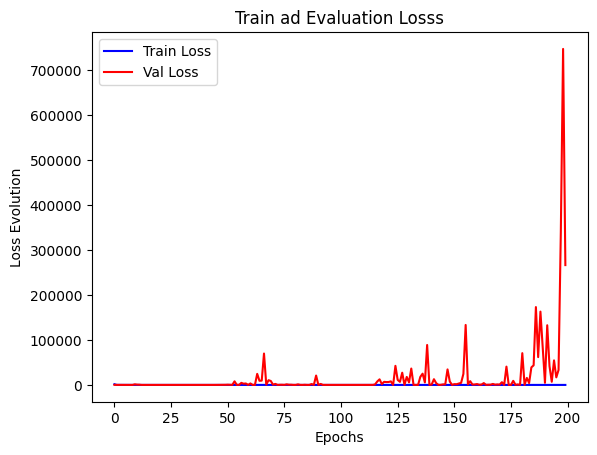

testing data:   0%|          | 0/21 [00:00<?, ?it/s]

MSE: tensor(37.0079, device='cuda:0')
RMSE: tensor(6.0834, device='cuda:0')
MAE: tensor(4.5371, device='cuda:0')
Spearman Corr: tensor(0.6891, device='cuda:0')


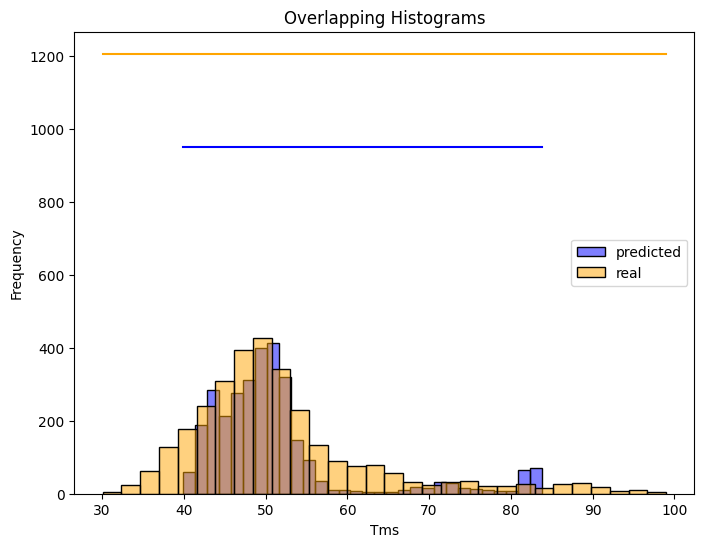

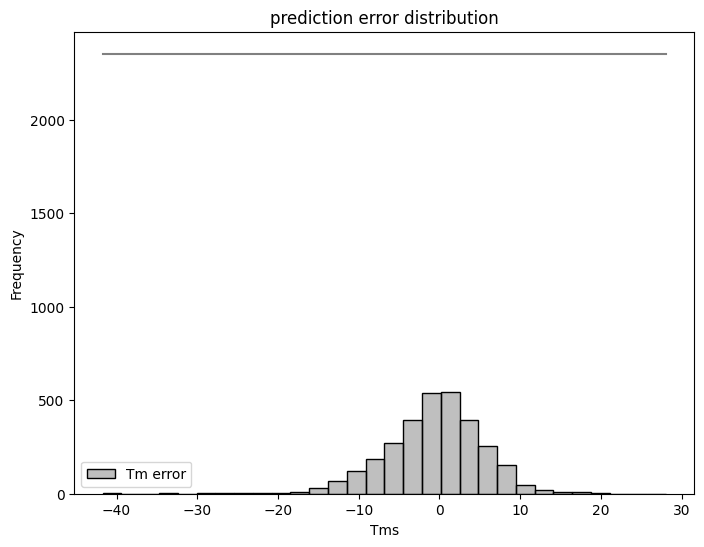

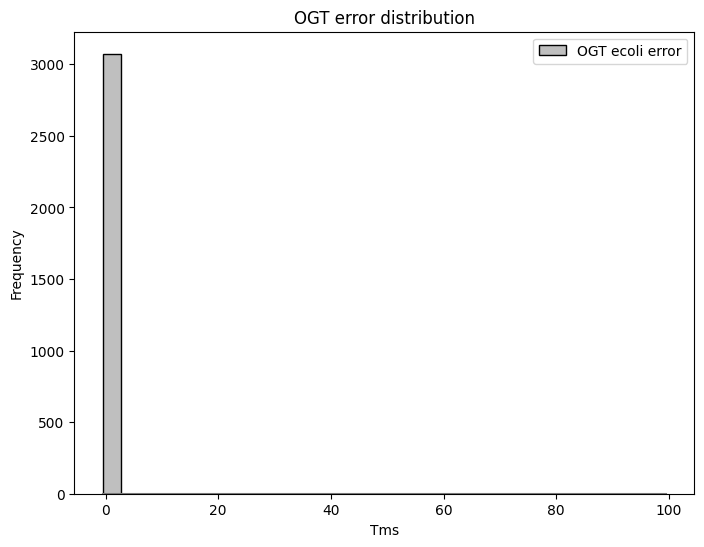

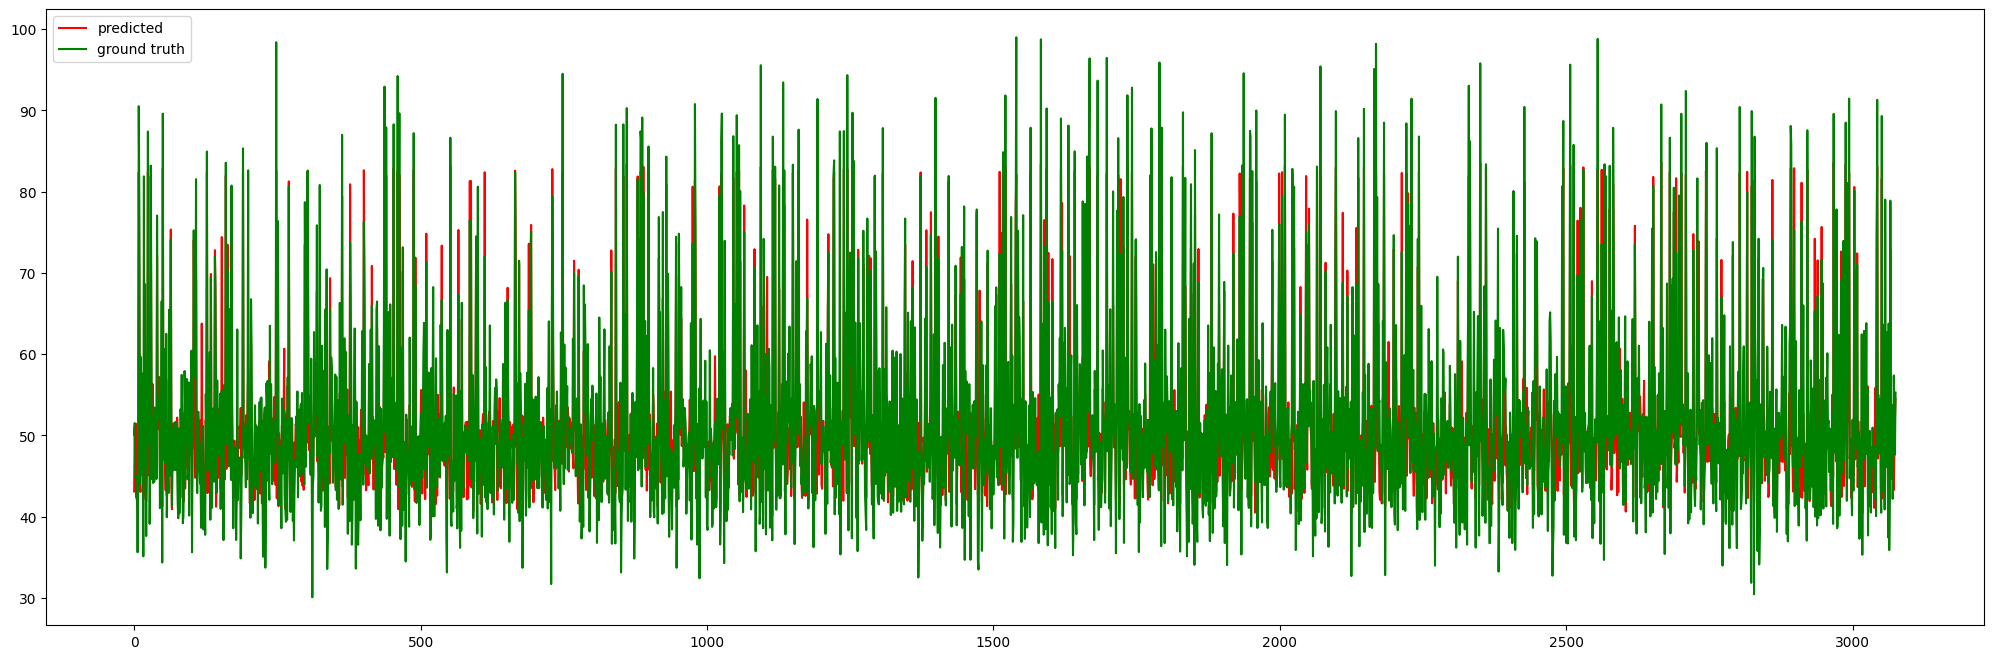

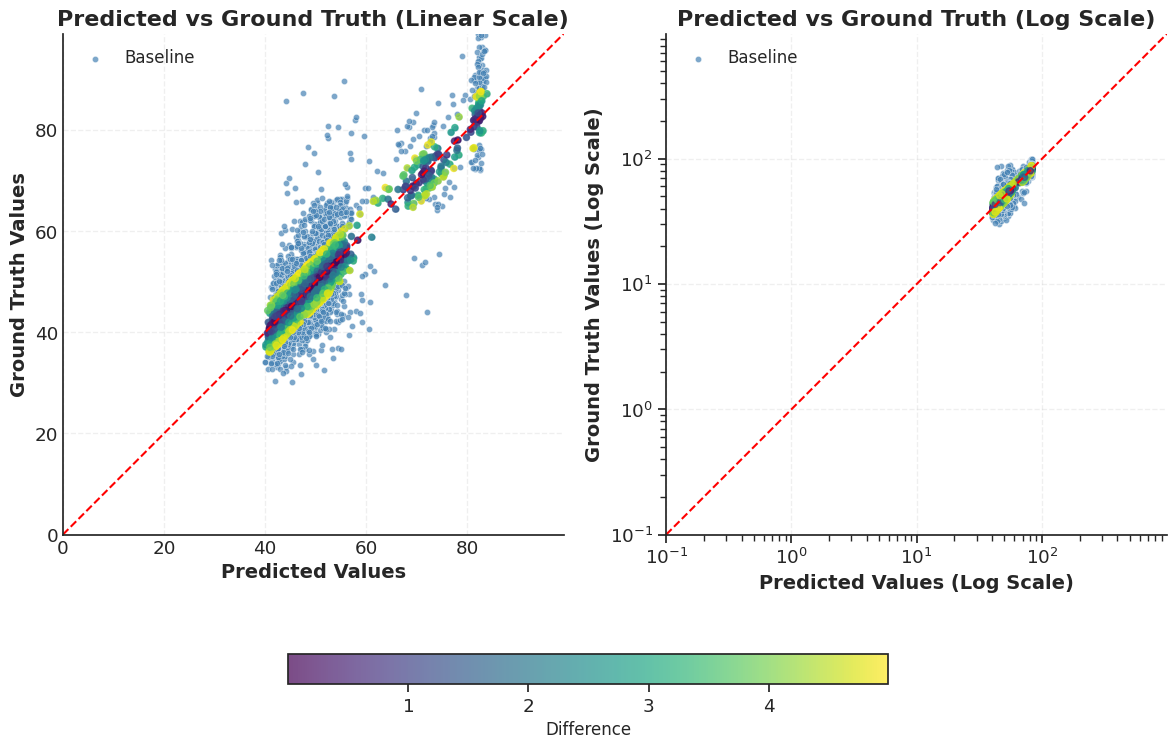

In [13]:

seq_struct_pred_W = LA_MLP_pred(embeddings_dim=1280, 
                                             output_dim=2, 
                                             dropout=0.25, 
                                             kernel_size=9, 
                                             conv_dropout= 0.25)
                                             #path_pretrained='../checkpoints/LA_MLP_TaskVectorBias_Merged_allnet_1_10_2023/')
# LightAttention(embeddings_dim=1280+128, output_dim=2, dropout=0.1, kernel_size=5, conv_dropout= 0.1)

optESM = torch.optim.AdamW(seq_struct_pred_W.parameters(), lr=1e-3)
lossESM= BiasOrganismLoss(device)#torch.nn.MSELoss()
epochs = 200

generating_results_approaches(seq_struct_pred_W, Trainer3, train_embedding_esm2, val_embedding_esm2, 
                              test_embedding_esm2, lossESM, optESM, epochs, device,
                              path_progres=path_progresESM, 
                              checkpoint_path=checkpoint_pathESM,
                              output_metrics=config['initial_paths']['output_metrics_ESM_only'])



### For Inverse Folding PiFold Using Prediction by Component (convolutions as a way of pooling + sum pooling to get the final predictions)

Directory '../checkpoints/PiFold_only/Global/AllMeltome_cleaned_globalAvgtm/' created


  0%|          | 0/200 [00:00<?, ?it/s]

training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 1 loss: 1449.588 val loss: 209.405


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 2 loss: 118.759 val loss: 104.515


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 3 loss: 101.059 val loss: 96.016


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 4 loss: 93.018 val loss: 91.980


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 5 loss: 85.781 val loss: 90.295


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 6 loss: 77.878 val loss: 93.186


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 7 loss: 73.784 val loss: 82.161


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 8 loss: 66.472 val loss: 84.176


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 9 loss: 62.171 val loss: 82.496


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 10 loss: 57.467 val loss: 91.145


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 11 loss: 54.199 val loss: 79.074


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 12 loss: 51.254 val loss: 72.883


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 13 loss: 47.077 val loss: 80.063


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 14 loss: 45.091 val loss: 84.810


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 15 loss: 43.057 val loss: 72.110


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 16 loss: 40.368 val loss: 79.504


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 17 loss: 39.304 val loss: 75.478


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 18 loss: 37.882 val loss: 92.713


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 19 loss: 38.152 val loss: 73.765


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 20 loss: 36.729 val loss: 79.389


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 21 loss: 34.512 val loss: 72.026


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 22 loss: 34.375 val loss: 74.117


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 23 loss: 34.005 val loss: 76.079


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 24 loss: 32.462 val loss: 76.536


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 25 loss: 31.740 val loss: 72.978


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 26 loss: 32.571 val loss: 82.715


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 27 loss: 31.395 val loss: 83.115


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 28 loss: 30.189 val loss: 81.352


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 29 loss: 30.282 val loss: 82.610


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 30 loss: 30.215 val loss: 77.872


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 31 loss: 28.854 val loss: 90.195


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 32 loss: 29.521 val loss: 73.753


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 33 loss: 28.355 val loss: 74.954


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 34 loss: 28.204 val loss: 75.075


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 35 loss: 27.100 val loss: 69.527


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 36 loss: 29.034 val loss: 73.187


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 37 loss: 35.192 val loss: 379.684


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 38 loss: 31.731 val loss: 199.977


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 39 loss: 30.372 val loss: 123.649


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 40 loss: 30.384 val loss: 123.165


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 41 loss: 29.067 val loss: 78.697


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 42 loss: 29.747 val loss: 96.940


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 43 loss: 27.244 val loss: 98.125


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 44 loss: 25.083 val loss: 91.426


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 45 loss: 24.741 val loss: 79.195


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 46 loss: 25.395 val loss: 85.441


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 47 loss: 24.442 val loss: 86.985


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 48 loss: 23.902 val loss: 86.338


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 49 loss: 23.316 val loss: 93.076


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 50 loss: 22.392 val loss: 95.971


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 51 loss: 23.036 val loss: 95.210


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 52 loss: 30.513 val loss: 98.843


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 53 loss: 26.489 val loss: 90.563


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 54 loss: 26.196 val loss: 94.544


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 55 loss: 24.214 val loss: 121.597


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 56 loss: 23.509 val loss: 140.785


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 57 loss: 23.269 val loss: 100.712


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 58 loss: 21.813 val loss: 103.686


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 59 loss: 20.643 val loss: 87.396


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 60 loss: 21.871 val loss: 102.799


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 61 loss: 19.313 val loss: 103.791


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 62 loss: 19.527 val loss: 134.470


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 63 loss: 19.816 val loss: 104.919


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 64 loss: 20.306 val loss: 92.079


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 65 loss: 18.648 val loss: 116.417


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 66 loss: 19.978 val loss: 123.421


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 67 loss: 18.487 val loss: 120.606


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 68 loss: 17.787 val loss: 114.732


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 69 loss: 17.212 val loss: 165.420


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 70 loss: 18.337 val loss: 114.708


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 71 loss: 17.798 val loss: 109.789


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 72 loss: 17.648 val loss: 131.779


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 73 loss: 17.193 val loss: 143.350


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 74 loss: 16.819 val loss: 127.465


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 75 loss: 16.865 val loss: 122.346


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 76 loss: 17.094 val loss: 155.549


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 77 loss: 16.712 val loss: 150.515


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 78 loss: 17.245 val loss: 172.816


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 79 loss: 17.504 val loss: 114.423


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 80 loss: 16.406 val loss: 111.530


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 81 loss: 16.073 val loss: 125.122


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 82 loss: 16.585 val loss: 126.764


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 83 loss: 16.851 val loss: 157.897


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 84 loss: 17.361 val loss: 146.039


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 85 loss: 15.363 val loss: 151.453


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 86 loss: 16.065 val loss: 158.966


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 87 loss: 15.177 val loss: 151.190


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 88 loss: 15.481 val loss: 163.428


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 89 loss: 16.161 val loss: 156.107


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 90 loss: 15.543 val loss: 116.824


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 91 loss: 15.006 val loss: 93.043


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 92 loss: 15.288 val loss: 131.668


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 93 loss: 14.862 val loss: 164.782


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 94 loss: 14.613 val loss: 132.155


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 95 loss: 14.652 val loss: 142.608


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 96 loss: 14.183 val loss: 130.768


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 97 loss: 15.122 val loss: 144.913


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 98 loss: 14.446 val loss: 146.881


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 99 loss: 14.720 val loss: 154.183


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 100 loss: 14.031 val loss: 154.514


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 101 loss: 13.707 val loss: 156.792


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 102 loss: 13.372 val loss: 148.487


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 103 loss: 14.745 val loss: 150.975


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 104 loss: 13.592 val loss: 140.416


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 105 loss: 13.143 val loss: 150.020


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 106 loss: 13.990 val loss: 180.727


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 107 loss: 12.981 val loss: 126.100


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 108 loss: 14.153 val loss: 124.133


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 109 loss: 13.266 val loss: 139.925


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 110 loss: 13.630 val loss: 128.750


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 111 loss: 16.049 val loss: 147.470


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 112 loss: 13.319 val loss: 117.100


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 113 loss: 13.137 val loss: 151.206


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 114 loss: 13.874 val loss: 178.508


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 115 loss: 12.863 val loss: 200.786


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 116 loss: 13.152 val loss: 142.408


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 117 loss: 14.869 val loss: 143.613


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 118 loss: 13.016 val loss: 167.603


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 119 loss: 13.077 val loss: 127.367


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 120 loss: 12.360 val loss: 106.391


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 121 loss: 12.963 val loss: 132.249


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 122 loss: 12.558 val loss: 124.157


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 123 loss: 13.277 val loss: 139.910


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 124 loss: 12.403 val loss: 155.210


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 125 loss: 12.848 val loss: 155.666


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 126 loss: 12.947 val loss: 150.212


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 127 loss: 12.054 val loss: 169.107


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 128 loss: 12.292 val loss: 141.070


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 129 loss: 12.659 val loss: 122.343


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 130 loss: 11.907 val loss: 123.856


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 131 loss: 13.114 val loss: 131.191


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 132 loss: 11.882 val loss: 112.725


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 133 loss: 12.405 val loss: 138.650


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 134 loss: 12.891 val loss: 135.004


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 135 loss: 12.921 val loss: 135.473


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 136 loss: 12.522 val loss: 136.269


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 137 loss: 11.579 val loss: 154.487


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 138 loss: 12.003 val loss: 117.022


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 139 loss: 11.840 val loss: 169.940


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 140 loss: 11.802 val loss: 156.246


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 141 loss: 11.934 val loss: 127.944


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 142 loss: 11.698 val loss: 157.053


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 143 loss: 11.240 val loss: 126.861


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 144 loss: 11.135 val loss: 170.158


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 145 loss: 11.494 val loss: 141.029


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 146 loss: 11.504 val loss: 155.785


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 147 loss: 12.500 val loss: 122.789


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 148 loss: 11.568 val loss: 142.644


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 149 loss: 11.530 val loss: 138.575


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 150 loss: 11.679 val loss: 115.236


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 151 loss: 11.440 val loss: 138.703


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 152 loss: 11.238 val loss: 188.091


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 153 loss: 11.564 val loss: 128.442


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 154 loss: 11.984 val loss: 128.883


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 155 loss: 10.974 val loss: 140.853


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 156 loss: 11.064 val loss: 132.307


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 157 loss: 10.389 val loss: 125.108


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 158 loss: 10.726 val loss: 141.006


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 159 loss: 10.830 val loss: 151.423


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 160 loss: 11.134 val loss: 131.195


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 161 loss: 10.897 val loss: 134.238


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 162 loss: 11.414 val loss: 149.547


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 163 loss: 11.055 val loss: 135.524


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 164 loss: 10.241 val loss: 143.373


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 165 loss: 11.129 val loss: 139.270


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 166 loss: 10.673 val loss: 146.361


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 167 loss: 10.558 val loss: 136.545


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 168 loss: 10.482 val loss: 115.597


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 169 loss: 10.840 val loss: 163.382


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 170 loss: 10.454 val loss: 143.217


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 171 loss: 10.422 val loss: 131.213


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 172 loss: 10.172 val loss: 127.507


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 173 loss: 10.267 val loss: 160.695


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 174 loss: 10.551 val loss: 155.951


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 175 loss: 10.476 val loss: 134.711


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 176 loss: 10.511 val loss: 114.550


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 177 loss: 10.294 val loss: 145.109


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 178 loss: 10.156 val loss: 112.997


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 179 loss: 10.212 val loss: 118.925


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 180 loss: 10.296 val loss: 148.719


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 181 loss: 9.484 val loss: 139.363


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 182 loss: 11.107 val loss: 136.950


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 183 loss: 9.981 val loss: 110.102


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 184 loss: 9.773 val loss: 138.110


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 185 loss: 9.771 val loss: 146.300


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 186 loss: 9.635 val loss: 133.247


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 187 loss: 10.130 val loss: 115.963


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 188 loss: 10.236 val loss: 124.208


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 189 loss: 9.624 val loss: 138.303


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 190 loss: 9.238 val loss: 134.133


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 191 loss: 9.875 val loss: 143.269


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 192 loss: 9.829 val loss: 132.118


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 193 loss: 10.607 val loss: 120.250


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 194 loss: 9.513 val loss: 125.118


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 195 loss: 10.323 val loss: 127.709


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 196 loss: 9.493 val loss: 118.728


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 197 loss: 9.621 val loss: 114.351


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 198 loss: 10.248 val loss: 128.853


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 199 loss: 10.366 val loss: 100.606


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 200 loss: 10.018 val loss: 149.286


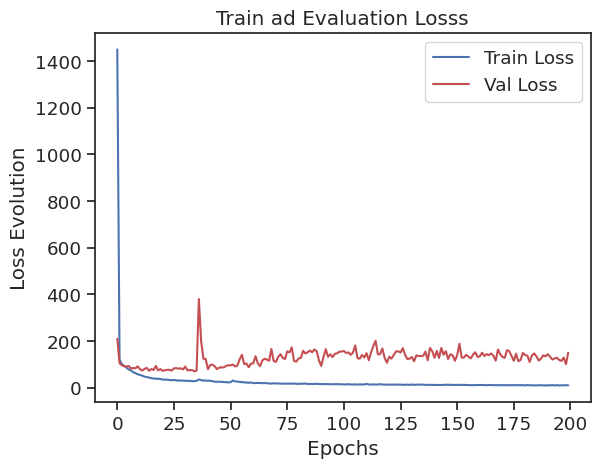

testing data:   0%|          | 0/21 [00:00<?, ?it/s]

MSE: tensor(202.4148, device='cuda:0')
RMSE: tensor(14.2273, device='cuda:0')
MAE: tensor(7.1636, device='cuda:0')
Spearman Corr: tensor(0.3637, device='cuda:0')


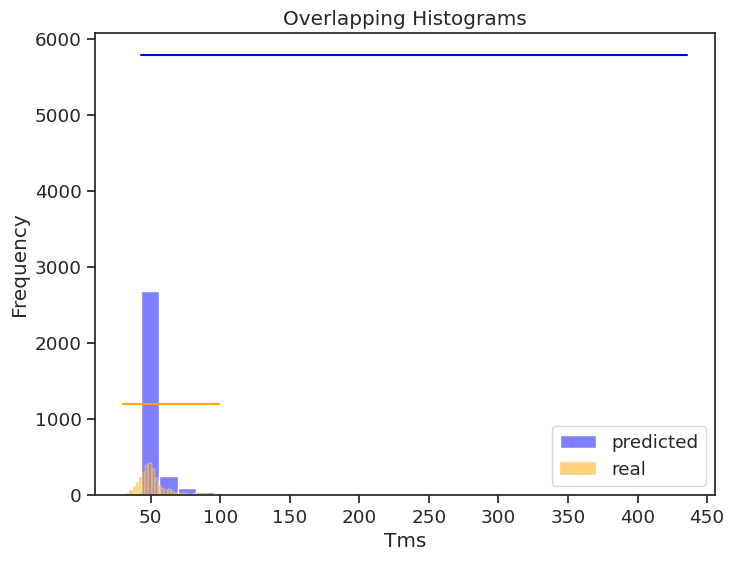

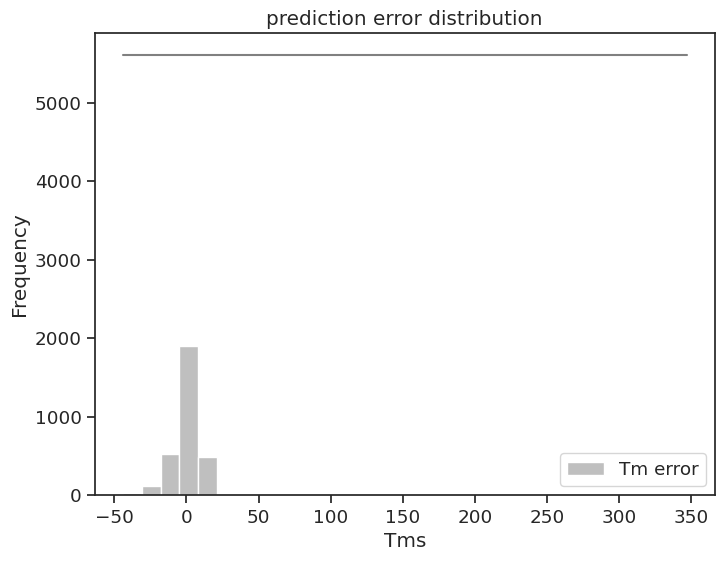

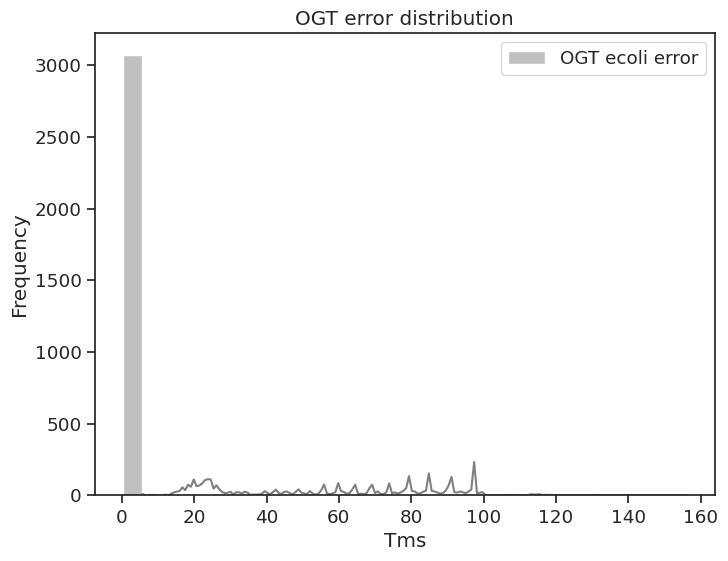

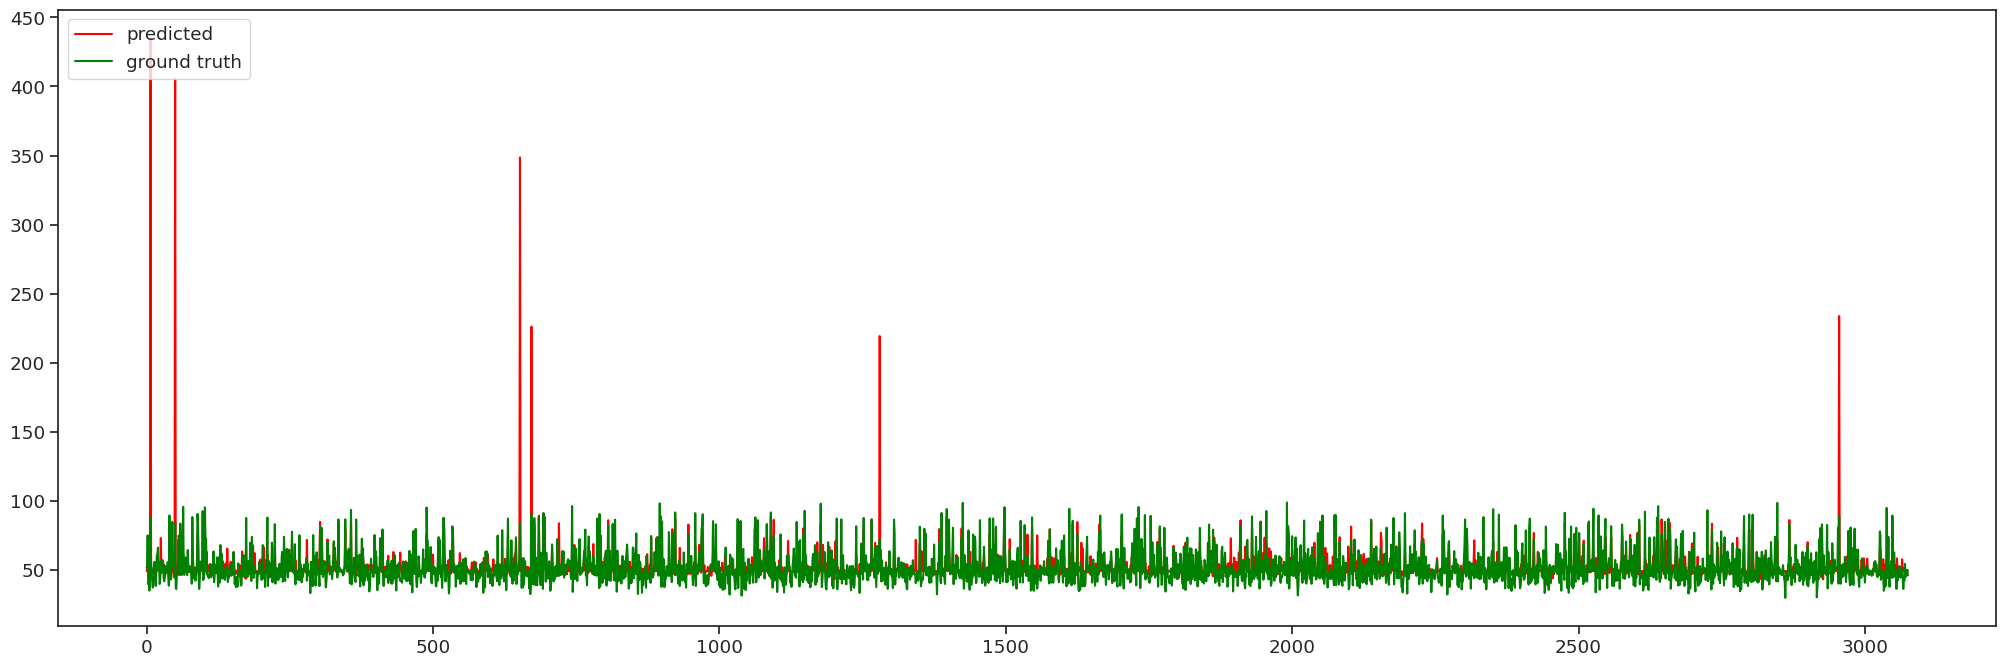

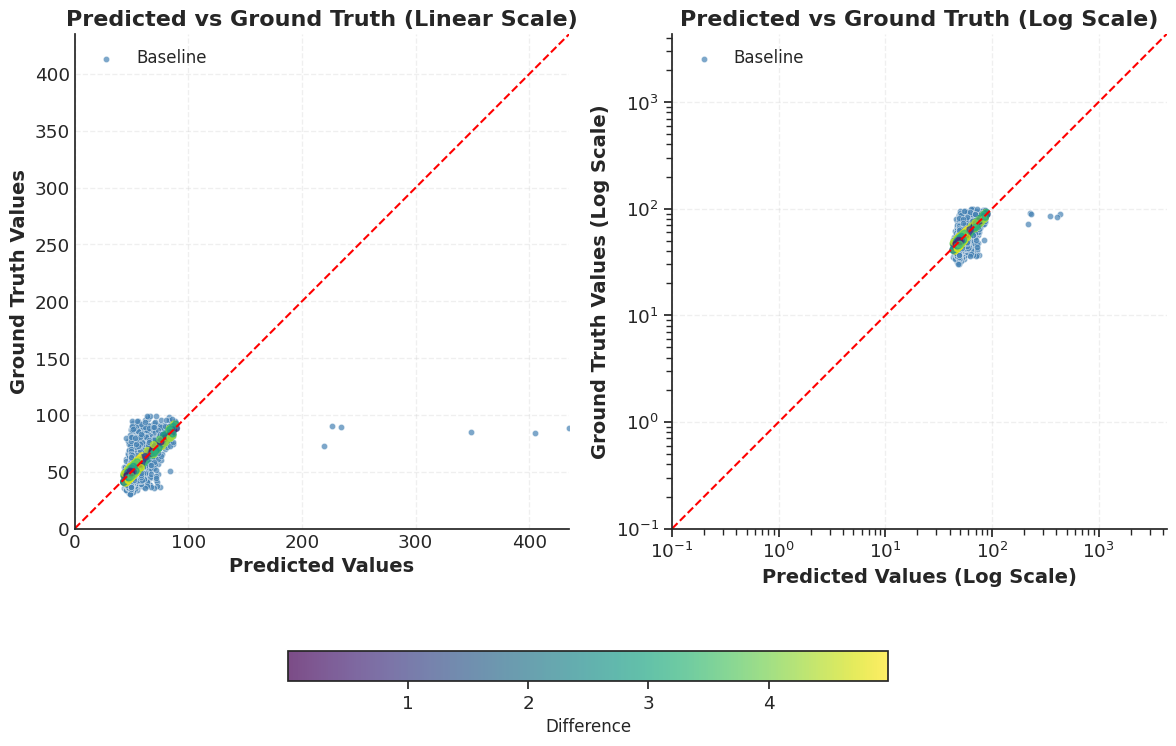

In [14]:

seq_struct_pred_W_PiFold = LA_MLP_pred(embeddings_dim=128, 
                                             output_dim=2, 
                                             dropout=0.25, 
                                             kernel_size=9, 
                                             conv_dropout= 0.25)
                                             #path_pretrained='../checkpoints/LA_MLP_TaskVectorBias_Merged_allnet_1_10_2023/')
# LightAttention(embeddings_dim=1280+128, output_dim=2, dropout=0.1, kernel_size=5, conv_dropout= 0.1)


optPiFold = torch.optim.AdamW(seq_struct_pred_W_PiFold.parameters(), lr=1e-3)
lossPiFold= BiasOrganismLoss(device)#torch.nn.MSELoss()
epochs = 200

generating_results_approaches(seq_struct_pred_W_PiFold, Trainer3, train_embedding_PiFold, val_embedding_PiFold, 
                              test_embedding_PiFold, lossPiFold, optPiFold, epochs, device,
                              path_progres=path_progresPiFold, 
                              checkpoint_path=checkpoint_pathPiFold,
                              output_metrics=config['initial_paths']['output_metrics_PiFold_only'])


### For Both ESM2 and Inverse Folding PiFold Contributions Together Using Prediction by Component (convolutions as a way of pooling + sum pooling to get the final predictions)

In [15]:

import torchsort, sys
sys.path.append(os.path.abspath("../ref_models/fast_soft_sort"))
from ref_models.fast_soft_sort.fast_soft_sort.pytorch_ops import soft_rank, soft_sort

#import ipdb; ipdb.set_trace()
seq_struct_pred_W_merged = LA_MLP_pred(embeddings_dim=1280+128, 
                                             output_dim=2, 
                                             dropout=0.25, 
                                             kernel_size=9, 
                                             conv_dropout= 0.25)
                                             #path_pretrained='../checkpoints/LA_MLP_TaskVectorBias_Merged_allnet_1_10_2023/')
# LightAttention(embeddings_dim=1280+128, output_dim=2, dropout=0.1, kernel_size=5, conv_dropout= 0.1)


optIFM = torch.optim.AdamW(seq_struct_pred_W_merged.parameters(), lr=1e-3)
lossIFM= BiasOrganismLoss(device)#torch.nn.MSELoss()
epochs = 200

generating_results_approaches(seq_struct_pred_W_merged, Trainer3, train_embedding_merged, val_embedding_merged, 
                              test_embedding_merged, lossIFM, optIFM, epochs, device,
                              path_progres=path_progresMix, 
                              checkpoint_path=checkpoint_pathMix,
                              output_metrics=config['initial_paths']['output_metrics_Both'])


Directory '../checkpoints/Mix/Global/AllMeltome_cleaned_globalAvgtm/' created


  0%|          | 0/200 [00:00<?, ?it/s]

training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 1 loss: 1551.557 val loss: 90.869


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 2 loss: 67.193 val loss: 46.156


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 3 loss: 44.597 val loss: 39.279


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 4 loss: 37.551 val loss: 47.055


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 5 loss: 34.416 val loss: 45.921


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 6 loss: 29.347 val loss: 40.998


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 7 loss: 26.275 val loss: 43.178


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 8 loss: 59.582 val loss: 42.003


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 9 loss: 36.609 val loss: 42.089


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 10 loss: 32.367 val loss: 36.905


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 11 loss: 31.068 val loss: 44.977


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 12 loss: 28.295 val loss: 48.346


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 13 loss: 25.523 val loss: 45.302


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 14 loss: 25.277 val loss: 39.779


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 15 loss: 23.244 val loss: 38.200


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 16 loss: 21.988 val loss: 40.841


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 17 loss: 24.091 val loss: 43.878


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 18 loss: 20.452 val loss: 39.417


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 19 loss: 22.289 val loss: 47.710


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 20 loss: 21.613 val loss: 43.471


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 21 loss: 19.787 val loss: 42.952


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 22 loss: 19.883 val loss: 42.886


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 23 loss: 19.550 val loss: 44.255


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 24 loss: 17.872 val loss: 43.957


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 25 loss: 17.937 val loss: 39.337


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 26 loss: 17.465 val loss: 43.263


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 27 loss: 16.884 val loss: 37.759


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 28 loss: 17.320 val loss: 40.370


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 29 loss: 18.216 val loss: 41.012


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 30 loss: 16.739 val loss: 39.869


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 31 loss: 15.926 val loss: 39.833


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 32 loss: 16.390 val loss: 44.696


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 33 loss: 15.579 val loss: 43.089


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 34 loss: 15.382 val loss: 38.857


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 35 loss: 15.008 val loss: 43.648


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 36 loss: 16.316 val loss: 40.979


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 37 loss: 16.134 val loss: 40.195


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 38 loss: 16.068 val loss: 40.475


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 39 loss: 15.008 val loss: 39.008


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 40 loss: 16.445 val loss: 46.476


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 41 loss: 16.224 val loss: 43.578


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 42 loss: 15.003 val loss: 46.469


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 43 loss: 15.792 val loss: 46.744


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 44 loss: 13.727 val loss: 40.917


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 45 loss: 14.604 val loss: 40.646


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 46 loss: 15.125 val loss: 41.022


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 47 loss: 15.043 val loss: 42.414


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 48 loss: 15.340 val loss: 41.074


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 49 loss: 15.512 val loss: 46.795


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 50 loss: 15.540 val loss: 47.967


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 51 loss: 14.796 val loss: 44.527


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 52 loss: 14.270 val loss: 42.820


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 53 loss: 13.490 val loss: 40.818


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 54 loss: 15.531 val loss: 45.159


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 55 loss: 14.481 val loss: 43.407


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 56 loss: 14.183 val loss: 47.566


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 57 loss: 13.796 val loss: 42.636


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 58 loss: 14.275 val loss: 42.681


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 59 loss: 13.457 val loss: 48.698


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 60 loss: 14.365 val loss: 41.913


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 61 loss: 14.851 val loss: 39.060


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 62 loss: 14.868 val loss: 42.944


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 63 loss: 13.947 val loss: 45.924


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 64 loss: 15.294 val loss: 54.841


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 65 loss: 16.782 val loss: 40.376


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 66 loss: 13.912 val loss: 39.620


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 67 loss: 15.499 val loss: 41.745


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 68 loss: 13.401 val loss: 41.841


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 69 loss: 14.932 val loss: 44.378


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 70 loss: 14.416 val loss: 48.023


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 71 loss: 15.227 val loss: 45.228


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 72 loss: 14.295 val loss: 49.601


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 73 loss: 14.307 val loss: 41.470


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 74 loss: 13.470 val loss: 45.306


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 75 loss: 13.593 val loss: 43.675


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 76 loss: 14.165 val loss: 74.209


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 77 loss: 13.812 val loss: 43.889


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 78 loss: 14.352 val loss: 328.221


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 79 loss: 14.917 val loss: 305.732


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 80 loss: 13.704 val loss: 514.819


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 81 loss: 13.700 val loss: 44.236


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 82 loss: 14.404 val loss: 39.309


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 83 loss: 13.903 val loss: 44.220


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 84 loss: 13.764 val loss: 42.215


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 85 loss: 12.850 val loss: 41.316


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 86 loss: 13.396 val loss: 40.196


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 87 loss: 13.726 val loss: 41.806


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 88 loss: 13.518 val loss: 42.649


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 89 loss: 14.104 val loss: 43.563


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 90 loss: 14.444 val loss: 42.890


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 91 loss: 13.538 val loss: 42.704


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 92 loss: 14.166 val loss: 42.523


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 93 loss: 13.777 val loss: 41.781


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 94 loss: 12.677 val loss: 42.853


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 95 loss: 14.111 val loss: 41.639


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 96 loss: 13.561 val loss: 41.442


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 97 loss: 13.561 val loss: 42.674


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 98 loss: 14.401 val loss: 44.080


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 99 loss: 12.253 val loss: 3120.398


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 100 loss: 14.651 val loss: 41.440


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 101 loss: 13.546 val loss: 43.942


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 102 loss: 13.119 val loss: 53.286


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 103 loss: 13.204 val loss: 41.105


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 104 loss: 14.133 val loss: 47.099


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 105 loss: 14.256 val loss: 46.501


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 106 loss: 13.597 val loss: 42.077


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 107 loss: 12.795 val loss: 43.669


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 108 loss: 12.764 val loss: 44.648


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 109 loss: 13.245 val loss: 43.677


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 110 loss: 13.637 val loss: 50.961


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 111 loss: 13.639 val loss: 237.917


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 112 loss: 13.165 val loss: 7373.993


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 113 loss: 13.810 val loss: 46.745


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 114 loss: 12.515 val loss: 43.029


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 115 loss: 13.903 val loss: 43.954


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 116 loss: 14.104 val loss: 49.759


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 117 loss: 13.281 val loss: 375.267


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 118 loss: 11.999 val loss: 80.447


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 119 loss: 12.364 val loss: 245.017


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 120 loss: 13.271 val loss: 1762.812


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 121 loss: 13.160 val loss: 3882.672


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 122 loss: 13.812 val loss: 1940.518


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 123 loss: 12.956 val loss: 441.591


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 124 loss: 13.229 val loss: 1655.784


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 125 loss: 13.156 val loss: 171.247


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 126 loss: 13.788 val loss: 281.280


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 127 loss: 13.460 val loss: 1554.185


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 128 loss: 12.443 val loss: 3938.171


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 129 loss: 13.557 val loss: 946.963


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 130 loss: 12.293 val loss: 2366.302


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 131 loss: 13.811 val loss: 300.511


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 132 loss: 13.332 val loss: 74.904


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 133 loss: 12.901 val loss: 2090.964


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 134 loss: 13.259 val loss: 5278.216


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 135 loss: 13.334 val loss: 22867.262


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 136 loss: 13.198 val loss: 2237.142


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 137 loss: 13.340 val loss: 1144.046


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 138 loss: 13.170 val loss: 805.185


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 139 loss: 12.218 val loss: 59.511


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 140 loss: 13.399 val loss: 9128.245


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 141 loss: 12.638 val loss: 73.772


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 142 loss: 11.674 val loss: 249.665


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 143 loss: 12.552 val loss: 47.904


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]

epoch: 144 loss: 13.110 val loss: 101.357


training epoch by batches:   0%|          | 0/136 [00:00<?, ?it/s]